In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.table
import GCRCatalogs
import os
import warnings; warnings.simplefilter('ignore')
import healpy as hp
import healsparse as hsp
import skyproj
import pandas as pd

In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times"]
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
%matplotlib inline
plt.rcParams.update({'font.size':14})

# Code to generate the matched catalog file:
## This should only need to be run once...

In [3]:
gcn = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2_with_addons')

In [4]:
# gcn.list_all_quantities()

In [6]:
matched_path = '/global/cfs/projectdirs/lsst/groups/LSS/DC2_R2.2i/dr6'
gc = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2_with_addons')
# gc = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6')
tracts = gc.available_tracts

In [8]:
# This cell should only have to be run once

data_matched = []
for ii, tract in enumerate(tracts):
    if ii%10==0:
        print(ii)
    aux_data = astropy.table.Table(gc.get_quantities(['objectId', 'ra', 'dec', 'extendedness', 'mag_i_cModel',
                                                     'photoz_mean', 'photoz_mode'], 
                                                     native_filters=f'tract == {tract}',
                                                     filters=['mag_i_cModel < 24.92', 'detect_isPrimary == True',
                                                              'g_base_ClassificationExtendedness_value > 0.5',
                                                              'r_base_ClassificationExtendedness_value > 0.5',
                                                              'i_base_ClassificationExtendedness_value > 0.5',
                                                              'z_base_ClassificationExtendedness_value > 0.5',]))
    aux_data2 = astropy.table.Table.read(os.path.join(matched_path, f'matched_ids_dc2_object_run2.2i_dr6_{tract}.fits.gz'))
    aux_data2 = aux_data2[['objectId', 'redshift_true', 'n_neigh_truth', 'n_neigh_object', 'truthId', 'dist']]
    if len(aux_data)>0:
        tab_j = astropy.table.join(aux_data, aux_data2, keys='objectId', join_type='inner')
        data_matched.append(tab_j)
        
del aux_data
del aux_data2
del tab_j

tab_all = astropy.table.vstack(data_matched)
del data_matched

tab_all.write('/pscratch/sd/l/levine/table_object_matched_photoz_24p92_i_08-07-2024.fits.gz', overwrite=True)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


# Plots using CosmoDC2_small:

In [5]:
# Load in the truth catalog up to i<28
gc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
# data_truth = gc2.get_quantities(['galaxy_id', 'mag_i_lsst', 'ra', 'dec', 'redshift_true'], 
#                                 filters=['mag_i_lsst < 28', 'redshift_true <= 1.2'])
data_truth = gc2.get_quantities(['galaxy_id', 'mag_i_lsst', 'ra', 'dec', 'redshift_true'], 
                                filters=['redshift_true <= 1.2'])

In [6]:
# Load in the matched catalog, assuming it's already been created
tab_all = astropy.table.Table.read('/pscratch/sd/l/levine/table_object_matched_i_02-29-2024.fits.gz')

In [7]:
# Apply the depth mask
depthmap = hsp.HealSparseMap.read('/global/cfs/projectdirs/lsst/shared/DC2-prod/Run2.2i/addons/supreme/dr6-wfd/supreme_dc2_dr6d_v3_i_maglim_aper_wmean.hs')
depthmap_4096 = depthmap.generate_healpix_map(4096)

goodpx = np.where(depthmap_4096 > 24.92)
area_tot = np.count_nonzero(goodpx)*hp.nside2pixarea(4096, degrees=True)
print('Map area:', area_tot)

pxnums_obs_depth = hp.ang2pix(4096, tab_all['ra'], tab_all['dec'], lonlat=True, nest=True)
good_obs = np.in1d(pxnums_obs_depth, goodpx)
print('Objects kept:', np.count_nonzero(good_obs), '\nProportion:', np.count_nonzero(good_obs)/len(tab_all))
tab_all = tab_all[good_obs]

Map area: 295.4375102845837
Objects kept: 22364329 
Proportion: 0.980983138207674


In [8]:
# Apply the bright star mask
starmap = hp.fitsfunc.read_map('/global/cfs/projectdirs/lsst/groups/LSS/DC2_R2.2i/bright_star_maps/bo_mask_4096.fits', nest=True)
goodpx = np.where(starmap > .5)
print('Map area:', np.count_nonzero(goodpx)*hp.nside2pixarea(4096, degrees=True))

pxnums_obs = hp.ang2pix(4096, tab_all['ra'], tab_all['dec'], lonlat=True, nest=True)
good_obs = np.in1d(pxnums_obs, goodpx)
print('Objects kept:', np.count_nonzero(good_obs), '\nProportion:', np.count_nonzero(good_obs)/len(tab_all))

tab_all = tab_all[good_obs]

Map area: 230.83853734108692
Objects kept: 17054563 
Proportion: 0.7625787923259402


In [9]:
# Total area of the final object catalog
map_observed = np.bincount(hp.ang2pix(2048, tab_all['ra'], tab_all['dec'], lonlat=True, nest=True), minlength=hp.nside2npix(2048))
goodpx = np.where(map_observed>0)[0]
print('Map area:', np.count_nonzero(goodpx)*hp.nside2pixarea(2048, degrees=True))

Map area: 294.16176755140873


In [10]:
# Now merge the truth and observed catalogs together
data_truth = pd.DataFrame(data_truth)
data_truth = data_truth.rename(columns={'galaxy_id':'truthId'})
tab_all = tab_all.to_pandas()
tab_all = tab_all.merge(data_truth, on='truthId')

In [11]:
galaxies = (tab_all['extendedness'] > 0.5)
oto = (tab_all['n_neigh_truth'] == 1) & (tab_all['n_neigh_object']==1)
mtm = (tab_all['n_neigh_truth'] > 1) & (tab_all['n_neigh_object']==1)

In [12]:
i_mag_deviation = (tab_all['mag_i_cModel'] - tab_all['mag_i_lsst'])
MAG_DEVIATION_LIMIT = .25
print(f'Fraction of one-to-one objects within {MAG_DEVIATION_LIMIT} mags of truth: \
{len(i_mag_deviation[i_mag_deviation < MAG_DEVIATION_LIMIT][oto & galaxies]) / len(i_mag_deviation[oto & galaxies]):.3f}')
print(f'Fraction of mult-to-one objects within {MAG_DEVIATION_LIMIT} mags of truth: \
{len(i_mag_deviation[i_mag_deviation < MAG_DEVIATION_LIMIT][mtm & galaxies]) / len(i_mag_deviation[mtm & galaxies]):.3f}')
print(f'Fraction of all objects within {MAG_DEVIATION_LIMIT} mags of truth: \
{len(i_mag_deviation[i_mag_deviation < MAG_DEVIATION_LIMIT][galaxies]) / len(i_mag_deviation[galaxies]):.3f}')

Fraction of one-to-one objects within 0.25 mags of truth: 0.956
Fraction of mult-to-one objects within 0.25 mags of truth: 0.966
Fraction of all objects within 0.25 mags of truth: 0.960


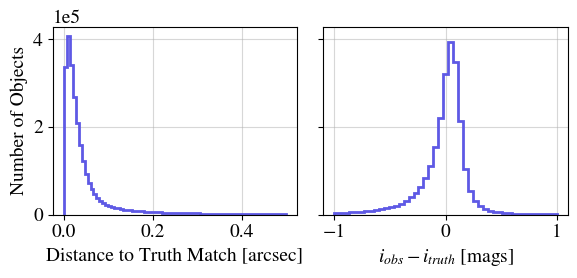

In [13]:
colorlist = ['#5e59e5', '#61ccbf', '#cca64f', '#e5197b']

fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True)
axs[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axs[0].hist(tab_all[galaxies]['dist'], 
            bins=75, histtype='step', color=colorlist[0], range=(0,.5), lw=2);
axs[0].set_xlabel('Distance to Truth Match [arcsec]')
axs[0].set_ylabel('Number of Objects')
axs[0].grid(alpha=.5)
# axs[0].set_yscale('log')

axs[1].hist((tab_all[galaxies]['mag_i_cModel'] - tab_all[galaxies]['mag_i_lsst']), 
            bins=45, histtype='step', color=colorlist[0], range=(-1,1), lw=2);
axs[1].set_xlabel('$i_{obs} - i_{truth}$ [mags]')
axs[1].grid(alpha=.5)
fig.tight_layout()
plt.savefig('dist_and_magnitude.png', format='png', dpi=300, bbox_inches='tight')

In [14]:
# Now let's reset everything for the main run, to be more memory efficient...
del tab_all
del data_truth
del galaxies
del oto
del mtm
del i_mag_deviation

# Code to generate the main plots and correlation functions:

In [3]:
gc = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6')
gc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

We select objects with $i < 24.1$ to have 90% completeness or better.

In [4]:
data_truth = gc2.get_quantities(['galaxy_id', 'mag_i_lsst', 'ra', 'dec', 'redshift_true'], 
                                filters=['mag_i_lsst < 24.92', 'redshift_true <= 1.2'])

In [5]:
tab_all = astropy.table.Table.read('/pscratch/sd/l/levine/table_object_matched_photoz_24p92_i_08-07-2024.fits.gz')

In [6]:
tab_all = tab_all[tab_all['mag_i_cModel'] < 24.92]

In [ ]:
import matplotlib.colors
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(6,2.0))
ax = fig.add_subplot(111)
hist, xbins, ybins, im = ax.hist2d(tab_all['n_neigh_truth'] , tab_all['n_neigh_object'],
           range=[[1,10],[1,4]], bins=[np.arange(0.5, 11, 1), np.arange(0.5, 5, 1)],
           density=True, norm=matplotlib.colors.LogNorm(), cmap='pink_r')
ax.set_xticks(np.arange(1, 11, 1.0))
ax.set_yticks(np.arange(1, 6, 1.0))
ax.set_xlabel('Number of True Neighbors')
ax.set_ylabel('Number of\nObserved Neighbors')
fig.colorbar(im, ax=ax)

neigh_hist = plt.hist2d(tab_all['n_neigh_truth'], tab_all['n_neigh_object'],
           range=[[1,10],[1,4]],bins=[np.arange(0.5, 11, 1), np.arange(0.5, 5, 1)],
           density=True,norm=matplotlib.colors.LogNorm(),cmap='pink_r')

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        if hist.T[i,j] >= 0.001:
            ax.text(xbins[j]+0.5,ybins[i]+0.5, f"{hist.T[i,j]:.3f}", 
                    color="w", ha="center", va="center", fontweight="bold", size=10)
            
ax.add_patch(plt.Rectangle((1.535, 0.5), 8.965, 1, fill=False, edgecolor='#f7bd36', lw=2, zorder=10, clip_on=False))
ax.add_patch(plt.Rectangle((0.5, 0.5), 0.965, 1, fill=False, edgecolor='#61ccbf', lw=2, zorder=10, clip_on=False))
            
mtm_patch = mpatches.Patch(color='#f7bd36', label='Multiple-to-One')
oto_patch = mpatches.Patch(color='#61ccbf', label='One-to-One')
ax.legend(handles=[oto_patch, mtm_patch], loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=2, fancybox=False, framealpha=1, edgecolor='1')

plt.savefig('2dhist_Y5photz.png', format='png', dpi=300, bbox_inches='tight')

# Apply healpix masks
### Starting off with the depth mask:

In [7]:
depthmap = hsp.HealSparseMap.read('/global/cfs/projectdirs/lsst/shared/DC2-prod/Run2.2i/addons/supreme/dr6-wfd/supreme_dc2_dr6d_v3_i_maglim_aper_wmean.hs')
depthmap_4096 = depthmap.generate_healpix_map(4096)

In [8]:
goodpx = np.where(depthmap_4096 > 24.92)
area_tot = np.count_nonzero(goodpx)*hp.nside2pixarea(4096, degrees=True)
print('Map area:', area_tot)

Map area: 288.3096614705418


In [9]:
pxnums_obs_depth = hp.ang2pix(4096, tab_all['ra'], tab_all['dec'], lonlat=True, nest=True)
good_obs = np.in1d(pxnums_obs_depth, goodpx)
print('Objects kept:', np.count_nonzero(good_obs), '\nProportion:', np.count_nonzero(good_obs)/len(tab_all))
tab_all = tab_all[good_obs]

Objects kept: 39690690 
Proportion: 0.9596151451667693


### Now applying the bright star mask:

In [10]:
starmap = hp.fitsfunc.read_map('/global/cfs/projectdirs/lsst/groups/LSS/DC2_R2.2i/bright_star_maps/bo_mask_4096.fits', nest=True)

In [11]:
goodpx = np.where(starmap > .5)
print('Map area:', np.count_nonzero(goodpx)*hp.nside2pixarea(4096, degrees=True))
pxnums_obs = hp.ang2pix(4096, tab_all['ra'], tab_all['dec'], lonlat=True, nest=True)
good_obs = np.in1d(pxnums_obs, goodpx)
print('Objects kept:', np.count_nonzero(good_obs), '\nProportion:', np.count_nonzero(good_obs)/len(tab_all))
tab_all = tab_all[good_obs]

Map area: 230.83853734108692
Objects kept: 30285198 
Proportion: 0.7630302723384249


In [12]:
map_observed = np.bincount(hp.ang2pix(2048, tab_all['ra'], tab_all['dec'], lonlat=True, nest=True), minlength=hp.nside2npix(2048))
goodpx = np.where(map_observed>0)[0]
print('Map area:', np.count_nonzero(goodpx)*hp.nside2pixarea(2048, degrees=True))

Map area: 287.6457670832166


# Make the random catalogs

In [14]:
ra_rnd = 48 + (77-48) * np.random.random(size=10000000)
cth_min = np.sin(np.radians(-47))
cth_max = np.sin(np.radians(-24))
cth_rnd = cth_min + (cth_max - cth_min)*np.random.random(size=len(ra_rnd))
dec_rnd = np.degrees(np.arcsin(cth_rnd))

In [15]:
#Remove randoms outside the observed area
map_observed = np.bincount(hp.ang2pix(4096, tab_all['ra'], tab_all['dec'], lonlat=True, nest=True), minlength=hp.nside2npix(4096))
goodpx = np.where(map_observed>0)[0]

pxnums = hp.ang2pix(4096, ra_rnd, dec_rnd, lonlat=True, nest=True)
good_rnd = np.in1d(pxnums, goodpx)
ra_rnd = ra_rnd[good_rnd]
dec_rnd = dec_rnd[good_rnd]

In [16]:
del good_rnd
del cth_rnd

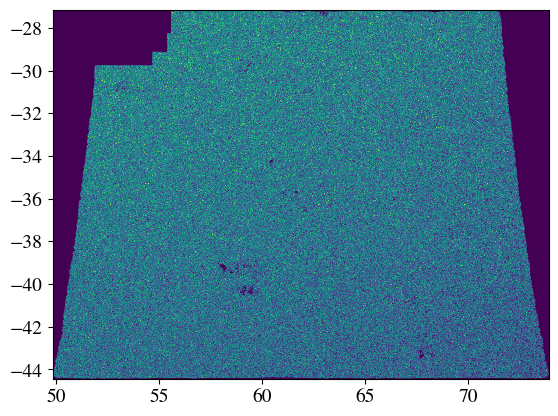

In [17]:
plt.hist2d(ra_rnd, dec_rnd, bins=500);

# Make random TreeCorr catalog

In [18]:
import treecorr as tc

In [19]:
cat_rnd = tc.Catalog(ra=ra_rnd, dec=dec_rnd, ra_units='deg', dec_units='deg', npatch=30)

In [20]:
minsep = 1
maxsep = 250

In [21]:
rr = tc.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=12, sep_units='arcmin')
rr.process(cat_rnd)

# Define object masks

In [13]:
np.max(tab_all['mag_i_cModel'])

24.919999963448014

In [14]:
galaxies = (tab_all['extendedness'] > 0.5)
oto = (tab_all['n_neigh_truth'] == 1) & (tab_all['n_neigh_object'] == 1)
mtm = (tab_all['n_neigh_truth'] > 1) & (tab_all['n_neigh_object'] == 1)
shred = (tab_all['n_neigh_truth'] < tab_all['n_neigh_object'])
blend = (tab_all['n_neigh_truth'] > tab_all['n_neigh_object'])

In [15]:
colorlist = ['#5e59e5', '#61ccbf', '#cca64f', '#e5197b']

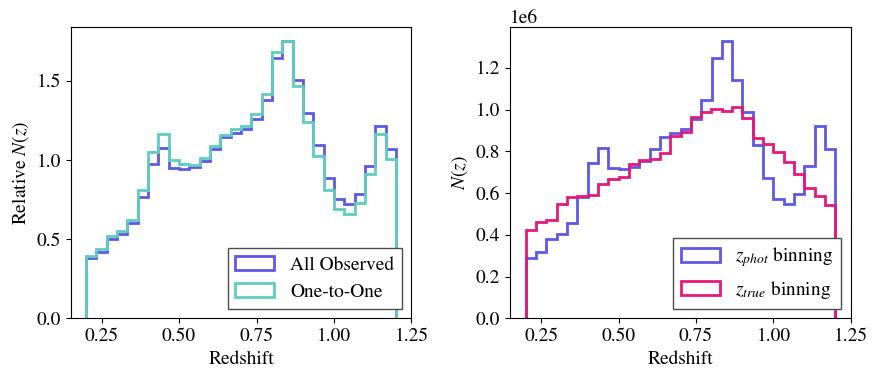

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
axs[0].hist(tab_all['photoz_mean'][galaxies], histtype='step', 
            lw=2, bins=30, range=(0.2,1.2), color=colorlist[0], density=True, label='All Observed');
axs[0].hist(tab_all['photoz_mean'][galaxies & oto], histtype='step', 
            lw=2, bins=30, range=(0.2,1.2), color=colorlist[1], density=True, label='One-to-One');
axs[0].set_xlabel('Redshift')
axs[0].set_ylabel('Relative $N(z)$')
axs[0].legend(loc='lower right', fancybox=False, framealpha=1, edgecolor='.3')

axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axs[1].hist(tab_all['photoz_mean'][galaxies], histtype='step', 
            lw=2, bins=30, range=(0.2,1.2), color=colorlist[0], density=False, label='$z_{phot}$ binning');
axs[1].hist(tab_all['redshift_true'][galaxies], histtype='step', 
            lw=2, bins=30, range=(0.2,1.2), color=colorlist[3], density=False, label='$z_{true}$ binning');
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel('$N(z)$')
axs[1].legend(loc='lower right', fancybox=False, framealpha=1, edgecolor='.3')

fig.tight_layout()
plt.savefig('Photoz_diagnostics_Y5_1.png', format='png', dpi=300, bbox_inches='tight')

In [16]:
z_colorcycle = ['#121413', '#205F69', '#49A078', '#9CC5A1', '#C7BE3B']

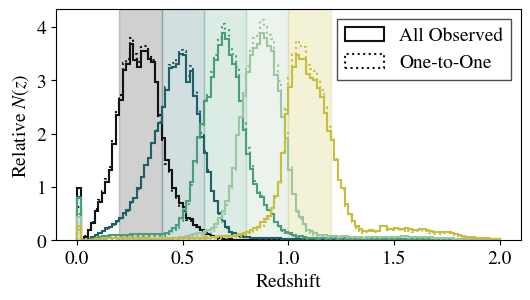

In [17]:
nbin = 120
redshift_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
plt.figure(figsize=(6,3))
for i in range(5):
    zmin = redshift_bin_edges[i]; zmax = redshift_bin_edges[i+1]
    plt.axvspan(zmin, zmax, color=z_colorcycle[i], alpha=.2)
    
    # Everything:
    zmask = (tab_all['photoz_mean'][galaxies] > zmin) & (tab_all['photoz_mean'][galaxies] < zmax)
    plt.hist(tab_all['redshift_true'][galaxies][zmask], histtype='step', 
                lw=1.5, bins=nbin, range=(0,2), color=z_colorcycle[i], density=True, label='All Observed')
    # One-to-one:
    zmask = (tab_all['photoz_mean'][galaxies & oto] > zmin) & (tab_all['photoz_mean'][galaxies & oto] < zmax)
    plt.hist(tab_all['redshift_true'][galaxies & oto][zmask], histtype='step', 
                lw=1.5, bins=nbin, range=(0,2), color=z_colorcycle[i], ls=':', density=True, label='One-to-One')
    
    if i==0:
        plt.legend(fancybox=False, framealpha=1, edgecolor='.3')
             
             
plt.xlabel('Redshift')
plt.ylabel('Relative $N(z)$')
plt.savefig('Photoz_diagnostics_Y5_2.png', format='png', dpi=300, bbox_inches='tight')

In [19]:
Nz_outdict = {}

#all
for i in range(5):
    zmin = redshift_bin_edges[i]; zmax = redshift_bin_edges[i+1]
    
    zmask = (tab_all['photoz_mean'][galaxies] > zmin) & (tab_all['photoz_mean'][galaxies] < zmax)
    all_cat = tab_all['redshift_true'][galaxies][zmask] 
    nz, zbins = calculate_z_distribution(all_cat, 0, 1)
    Nz_outdict[f'nz_all_{i}'] = nz
    Nz_outdict[f'zbins_all_{i}'] = zbins
    
    zmask = (tab_all['photoz_mean'][galaxies & oto] > zmin) & (tab_all['photoz_mean'][galaxies & oto] < zmax)
    oto_cat = tab_all['redshift_true'][galaxies & oto][zmask] 
    nz, zbins = calculate_z_distribution(oto_cat, 0, 1)
    Nz_outdict[f'nz_oto_{i}'] = nz
    Nz_outdict[f'zbins_oto_{i}'] = zbins
    
    zmask = (tab_all['photoz_mean'][galaxies & mtm] > zmin) & (tab_all['photoz_mean'][galaxies & mtm] < zmax)
    otm_cat = tab_all['redshift_true'][galaxies & mtm][zmask] 
    nz, zbins = calculate_z_distribution(otm_cat, 0, 1)
    Nz_outdict[f'nz_otm_{i}'] = nz
    Nz_outdict[f'zbins_otm_{i}'] = zbins

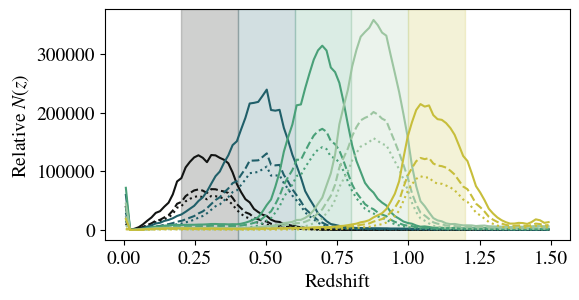

In [20]:
nbin = 120
redshift_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
plt.figure(figsize=(6,3))
for i in range(5):
    zmin = redshift_bin_edges[i]; zmax = redshift_bin_edges[i+1]
    plt.axvspan(zmin, zmax, color=z_colorcycle[i], alpha=.2)
    
    plt.plot(Nz_outdict[f'zbins_all_{i}'], Nz_outdict[f'nz_all_{i}'], color=z_colorcycle[i],)
    plt.plot(Nz_outdict[f'zbins_oto_{i}'], Nz_outdict[f'nz_oto_{i}'], color=z_colorcycle[i], ls=':')
    plt.plot(Nz_outdict[f'zbins_otm_{i}'], Nz_outdict[f'nz_otm_{i}'], color=z_colorcycle[i], ls='--')
    
    # if i==0:
    #     plt.legend(fancybox=False, framealpha=1, edgecolor='.3')
             
             
plt.xlabel('Redshift')
plt.ylabel('Relative $N(z)$')
plt.show()
# plt.savefig('Photoz_diagnostics_2.png', format='png', dpi=300, bbox_inches='tight')

In [21]:
import pickle
with open("pz_Nz_Y5.pkl", "wb") as f:
    pickle.dump(Nz_outdict, f)

In [14]:
map_obs = np.bincount(hp.ang2pix(4096, tab_all['ra'], tab_all['dec'], lonlat=True, nest=True), minlength=hp.nside2npix(4096))
goodpx = np.where(map_obs>0)[0]

pxnums = hp.ang2pix(4096, data_truth['ra'], data_truth['dec'], lonlat=True, nest=True)
good_truth = np.in1d(pxnums, goodpx)

lost = ~np.in1d(data_truth['galaxy_id'][good_truth], tab_all['truthId'])

In [15]:
print(np.count_nonzero(lost))

3372115


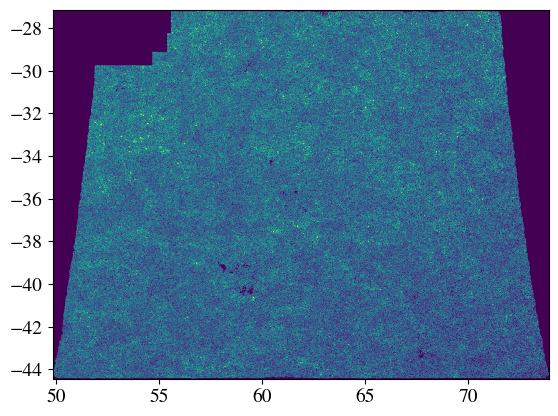

In [30]:
plt.hist2d(data_truth['ra'][good_truth], data_truth['dec'][good_truth], bins=500);

# Correlation function helpers

In [18]:
def compute_corr(cat, cat_rnd):
    dd = tc.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=12, sep_units='arcmin')
    dr = tc.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=12, sep_units='arcmin')
    dd.process(cat)
    dr.process(cat, cat_rnd)
    xi, _ = dd.calculateXi(rr, dr)
    cov_jk = dd.estimate_cov('jackknife')
    return dd.meanr, xi, cov_jk
def calculate_z_distribution(catalog, zmin, zmax):
    n_z, bin_edge = np.histogram(catalog, bins=100, range=(0, 1.5))
    bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]
    return n_z, bin_centers

In [19]:
galaxies = (tab_all['extendedness'] > 0.5)
oto = (tab_all['n_neigh_truth'] == 1) & (tab_all['n_neigh_object'] == 1)
mtm = (tab_all['n_neigh_truth'] > 1) & (tab_all['n_neigh_object'] == 1)
shred = (tab_all['n_neigh_truth'] < tab_all['n_neigh_object'])
blend = (tab_all['n_neigh_truth'] > tab_all['n_neigh_object'])

In [20]:
masks = {}
masks['all'] = galaxies
masks['1t1'] = (oto) & (galaxies)
masks['mtm'] = (mtm) & (galaxies)
masks['meas_other'] = (galaxies) & (~mtm) & (~oto)
masks['artifact'] = (galaxies) & (shred)
masks['true_all'] = np.ones(np.count_nonzero(good_truth), dtype=bool)
masks['true_lost'] = lost

# Maps

In [34]:
from matplotlib.gridspec import GridSpec

In [35]:
nside=2048

sq_deg_per_pixel = hp.pixelfunc.nside2pixarea(nside, degrees=True)
# So the conversion factor from galaxies/pixel to galaxies/sq_arcmin is n_gal * 1/(sq_deg_per_pixel) * 1/3600

pxvals = hp.ang2pix(nside, data_truth['ra'], data_truth['dec'], lonlat=True, nest=True)
px_unique, px_count = np.unique(pxvals, return_counts=True)
hp_true = np.zeros(hp.nside2npix(nside)) + hp.UNSEEN
hp_true[px_unique] = px_count / sq_deg_per_pixel / 3600

pxvals = hp.ang2pix(nside, tab_all['ra'], tab_all['dec'], lonlat=True, nest=True)
px_unique, px_count = np.unique(pxvals, return_counts=True)
hp_obs = np.zeros(hp.nside2npix(nside)) + hp.UNSEEN
hp_obs[px_unique] = px_count / sq_deg_per_pixel / 3600

KeyboardInterrupt: 

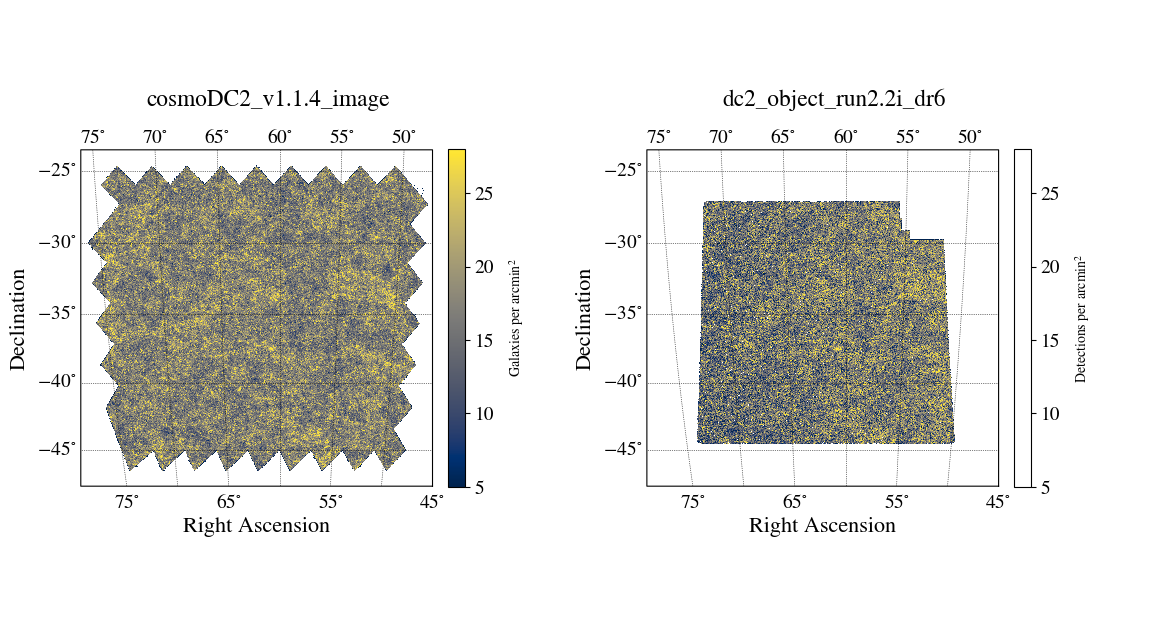

In [27]:
fig = plt.figure(1, figsize=(14, 8))
gs = GridSpec(1, 4, width_ratios=[1.05, .24, 1.05, .24], height_ratios=[1])
fig.clf()

ax1 = fig.add_subplot(gs[0])
sp = skyproj.McBrydeSkyproj(ax=ax1, lon_0=60, lat_0=-30, extent=[40, 80, -45, -20])
_ = sp.draw_hpxmap(hp_true, nest=True, cmap=plt.colormaps['cividis'], vmin=5, vmax=28)

ypad=.83
xpad=-2.68

cb1 = fig.add_subplot(gs[1], frame_on=False, visible=True, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
cb1.set_title('cosmoDC2_v1.1.4_image', y=ypad, x=xpad-.1)
cb1.yaxis.set_label_coords(0.16,0.5)
cb1.set_ylabel('Galaxies per arcmin$^2$', size=10)
plt.colorbar(fraction=0.044, pad=0.04)

ax2 = fig.add_subplot(gs[2])
sp = skyproj.McBrydeSkyproj(ax=ax2, lon_0=60, lat_0=-30, extent=[40, 80, -45, -20])

_ = sp.draw_hpxmap(hp_obs, nest=True, cmap=plt.colormaps['cividis'], vmin=5, vmax=28)
_ = sp.draw_hpxmap(hp_true, nest=True, cmap=plt.colormaps['cividis'], vmin=5, vmax=28, alpha=0)

cb2 = fig.add_subplot(gs[3], frame_on=False, visible=True, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
cb2.set_title('dc2_object_run2.2i_dr6', y=ypad, x=xpad-.1)
cb2.yaxis.set_label_coords(0.16,0.5)
cb2.set_ylabel('Detections per arcmin$^2$', size=10)
plt.colorbar(fraction=0.044, pad=0.04)

# plt.show()
plt.savefig('dc2_dr6.png', format='png', dpi=300, bbox_inches='tight')

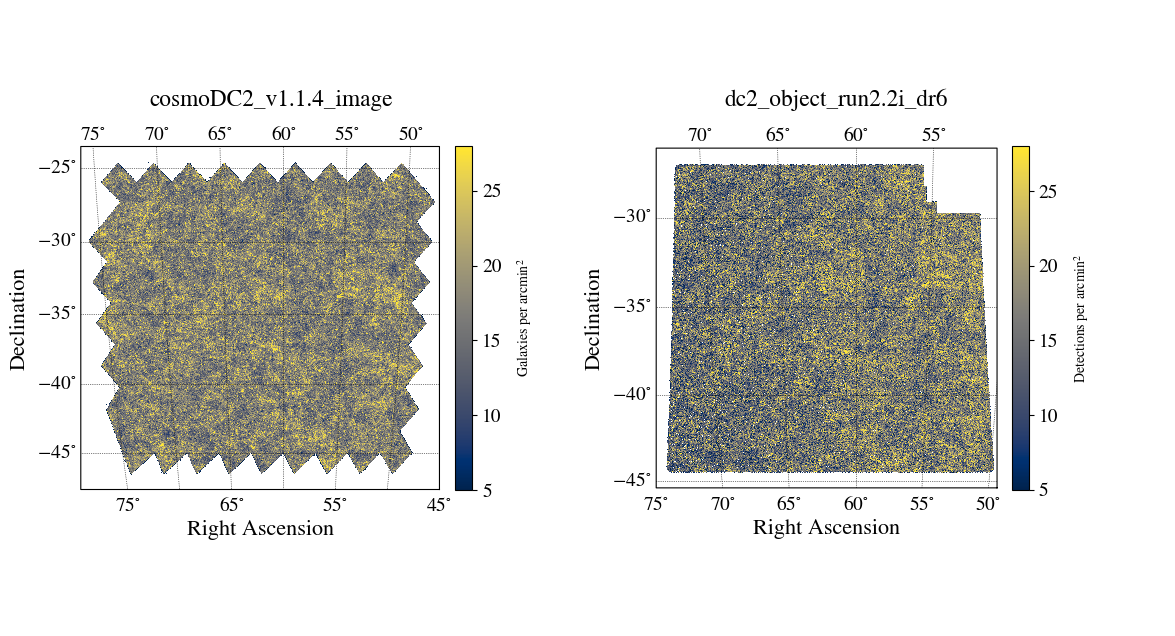

In [16]:
fig = plt.figure(1, figsize=(14, 8))
gs = GridSpec(1, 4, width_ratios=[1.05, .24, 1, .24], height_ratios=[1])
fig.clf()

ax1 = fig.add_subplot(gs[0])
sp = skyproj.McBrydeSkyproj(ax=ax1, lon_0=60, lat_0=-30, extent=[40, 80, -45, -20])
_ = sp.draw_hpxmap(hp_true, nest=True, cmap=plt.colormaps['cividis'], vmin=5, vmax=28)

ypad=.83
xpad=-2.68

cb1 = fig.add_subplot(gs[1], frame_on=False, visible=True, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
cb1.set_title('cosmoDC2_v1.1.4_image', y=ypad, x=xpad-.1)
cb1.yaxis.set_label_coords(0.16,0.5)
cb1.set_ylabel('Galaxies per arcmin$^2$', size=10)
plt.colorbar(fraction=0.044, pad=0.04)

ax2 = fig.add_subplot(gs[2])
sp = skyproj.McBrydeSkyproj(ax=ax2, lon_0=60, lat_0=-30, extent=[40, 80, -45, -20])
_ = sp.draw_hpxmap(hp_obs, nest=True, cmap=plt.colormaps['cividis'], vmin=5, vmax=28)

cb2 = fig.add_subplot(gs[3], frame_on=False, visible=True, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
cb2.set_title('dc2_object_run2.2i_dr6', y=ypad, x=xpad)
cb2.yaxis.set_label_coords(0.16,0.5)
cb2.set_ylabel('Detections per arcmin$^2$', size=10)
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()
# plt.savefig('dc2_dr6.png', format='png', dpi=300, bbox_inches='tight')

# Skysim5000 Maps

In [50]:
gc3 = GCRCatalogs.load_catalog('skysim5000_v1.1.2')
data_skysim = gc3.get_quantities(['ra', 'dec'], 
                                filters=['mag_i_lsst < 24.1', 'redshift_true <= 1.2'])

In [52]:
import matplotlib.patches as mpatches

In [53]:
nside=2048
# nside=4096

pxvals = hp.ang2pix(nside, data_truth['ra'], data_truth['dec'], lonlat=True)
px_unique_truth, px_count = np.unique(pxvals,return_counts=True)

pxvals = hp.ang2pix(nside, tab_all['ra'], tab_all['dec'], lonlat=True)
px_unique_obs, px_count = np.unique(pxvals,return_counts=True)

pxvals = hp.ang2pix(nside, data_skysim['ra'], data_skysim['dec'], lonlat=True)
px_unique, px_count = np.unique(pxvals,return_counts=True)
hp_skysim = np.zeros(hp.nside2npix(nside)) + hp.UNSEEN
hp_skysim[px_unique] = px_count

hp_skysim_cb = hp_skysim
hp_skysim_cb[px_unique] = 1
hp_skysim_cb[px_unique_truth] = 2
hp_skysim_cb[px_unique_obs] = 3

In [97]:
np.save('skysim_cb_hpmap.npy', hp_skysim_cb)

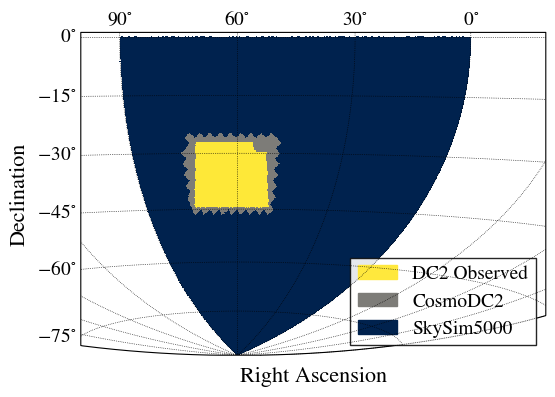

In [55]:
fig, ax = plt.subplots(1, figsize=(6, 6))

sp = skyproj.HammerSkyproj(ax=ax, lon_0=60, extent=[-20, 100, -89.9, 1], )
_ = sp.draw_hpxmap(hp_skysim_cb, nest=False, cmap=plt.colormaps['cividis'], zoom=False)

# Now create and show the labels:
skysim_patch = mpatches.Patch(color='#00224e', label='SkySim5000')
truth_patch = mpatches.Patch(color='#7d7c78', label='CosmoDC2')
obs_patch = mpatches.Patch(color='#ffe83d', label='DC2 Observed')
leg = plt.legend(handles=[obs_patch, truth_patch, skysim_patch], loc='lower right', fancybox=False, framealpha=.9, edgecolor='.05',)
leg.set_zorder(1e109)

# plt.show()
plt.savefig('skysim_plot.png', format='png', dpi=300, bbox_inches='tight')

# Summary Stats

In [21]:
print(f'''Frac. 1-1: {len(tab_all['redshift_true'][masks['1t1']])/len(tab_all['redshift_true'][masks['all']])}''')
print(f'''Frac. Mult-1: {len(tab_all['redshift_true'][masks['mtm']])/len(tab_all['redshift_true'][masks['all']])}''')

Frac. 1-1: 0.4081175341970637
Frac. Mult-1: 0.5861369172962694


In [22]:
len(tab_all['dist'][masks['all']][(tab_all['dist'][masks['all']]*180/np.pi) < 0])/len(tab_all['dist'][masks['all']])

0.002931632090342768

In [23]:
from scipy.stats import sem
def jackknife_resample(func, data, bins):
    '''Compute jackknife resampling for a given function 
    Inputs:
    ----------
    func - input function
    data - input data catalog
    bins - number of jackknife bins
    
    Returns:
    -------
    list of means for each output of the function
    list of standard deviations for each output of the function
    '''
    jk_bins = np.random.randint(0,high=bins,size=len(data))
    
    output_list = []
    for i in range(bins):
        output_list.append(func(data[jk_bins != i]))
    
    return np.mean(output_list,axis=0), sem(output_list,axis=0)

def propagate_division_error(z, x, dx, y, dy):
    '''Helper function to propagate division error 
    '''
    return np.multiply(np.sqrt(np.add(np.square(np.divide(dx,x)),np.square(np.divide(dy,y)))),z)

In [24]:
hist_statistic = lambda x: np.histogram(x, bins=100, range=(0.2,1.2), density=True)[0]
nz_oto, nz_sig_oto = jackknife_resample(hist_statistic, tab_all['photoz_mean'][masks['1t1']], 5)
nz_otm, nz_sig_otm = jackknife_resample(hist_statistic, tab_all['photoz_mean'][masks['mtm']], 5)
nz_all, nz_sig_all = jackknife_resample(hist_statistic, tab_all['photoz_mean'][masks['all']], 5)
nz_truth, nz_sig_truth = jackknife_resample(hist_statistic, data_truth['redshift_true'][good_truth][masks['true_all']], 5)
nz_lost, nz_sig_lost = jackknife_resample(hist_statistic, data_truth['redshift_true'][good_truth][masks['true_lost']], 5)

_, bin_edge = np.histogram(tab_all['redshift_true'][masks['1t1']], bins=100, range=(0.2, 1.2), density=True)
nz_bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]

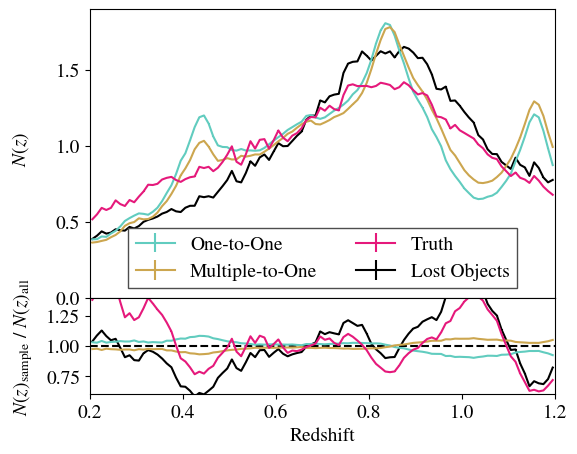

In [25]:
colorlist = ['#5e59e5', '#61ccbf', '#cca64f', '#e5197b']

fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [3, 1]}, figsize=(6,5))
plt.subplots_adjust(hspace=0.,wspace=0.)
axs[0].errorbar(nz_bin_centers, nz_oto, nz_sig_oto, color=colorlist[1])
axs[0].errorbar(nz_bin_centers, nz_otm, nz_sig_otm, color=colorlist[2])
axs[0].errorbar(nz_bin_centers, nz_truth, nz_sig_truth, color=colorlist[3])
# axs[0].errorbar(nz_bin_centers, nz_all, nz_sig_all, color=colorlist[0])
axs[0].errorbar(nz_bin_centers, nz_lost, nz_sig_lost, color='black', zorder=0)

axs[0].set_ylabel('  $N(z)$', labelpad=18)

axs[1].axhline(1,c='black',ls='--')
axs[1].errorbar(nz_bin_centers,np.divide(nz_oto,nz_all),
                propagate_division_error(np.divide(nz_oto,nz_all),nz_oto,nz_sig_oto,nz_all,nz_sig_all), color=colorlist[1])
axs[1].errorbar(nz_bin_centers,np.divide(nz_otm,nz_all),
                propagate_division_error(np.divide(nz_otm,nz_all),nz_otm,nz_sig_otm,nz_all,nz_sig_all), color=colorlist[2])
axs[1].errorbar(nz_bin_centers,np.divide(nz_truth,nz_all),
                propagate_division_error(np.divide(nz_truth,nz_all),nz_truth,nz_sig_truth,nz_all,nz_sig_all), color=colorlist[3])
axs[1].errorbar(nz_bin_centers,np.divide(nz_lost,nz_all),
                propagate_division_error(np.divide(nz_lost,nz_all),nz_lost,nz_sig_lost,nz_all,nz_sig_all), color='black', zorder=0)
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel('$N(z)_{\\rm sample}$ $/$ $N(z)_{\\rm all}$', labelpad=8)

axs[0].legend(['One-to-One', 'Multiple-to-One', 'Truth', 'Lost Objects'], 
              loc='lower center', ncol=2, fancybox=False, framealpha=1, edgecolor='.3')

axs[0].set_xlim(0.2,1.2)
axs[1].set_xlim(0.2,1.2)
axs[0].set_ylim(0, 1.9)
axs[1].set_ylim([.6,1.4])
# axs[0].set_ylim(0, 0.1)

axs[0].get_xaxis().set_visible(False)

plt.savefig('Nz_plot_Y5photz.png', format='png', dpi=300, bbox_inches='tight')

In [43]:
test_statistic = lambda x: (np.mean(x), np.median(x), np.std(x))
def print_statistics(catalog, zmin, zmax):
    '''Helper function to print mean, median, and st.dev for a given catalog
    Inputs:
    ----------
    catalog - input catalog (DataFrame)
    zmin, zmax - redshift bin edges
    
    Returns:
    -------
    None
    '''
    bin_mask = (catalog>zmin) & (catalog<zmax)
    a,b = jackknife_resample(test_statistic, catalog[bin_mask], 10)
    return a,b
    
zmin = 0.2; zmax = 1.2 
n_bins = 5
binlist = np.linspace(zmin,zmax,n_bins+1)

print('Redshift & One-to-One & Multiple-to-One & All Observed & Truth\\\\')
print('\hline')

idx=0 #mean
print('MEANS')
for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    stats_1t1 = print_statistics(tab_all['redshift_true'][masks['1t1']], zmin, zmax)
    stats_mtm = print_statistics(tab_all['redshift_true'][masks['mtm']], zmin, zmax)
    stats_all = print_statistics(tab_all['redshift_true'][masks['all']], zmin, zmax)
    stats_truth = print_statistics(data_truth['redshift_true'][good_truth][masks['true_all']], zmin, zmax)
    
    
    print(f'''{zmin:.1f}-{zmax:.1f} & 
${stats_1t1[0][idx]:.4f}$ & \
${stats_mtm[0][idx]:.4f}$ & \
${stats_all[0][idx]:.4f}$ & \
${stats_truth[0][idx]:.4f}$\\\\''')
print('\hline')  

idx=1 #median
print('MEDIANS')
zmin = 0.2; zmax = 1.2 
n_bins = 5
binlist = np.linspace(zmin,zmax,n_bins+1)

print('Redshift & One-to-One & Multiple-to-One & All Observed & Truth\\\\')
print('\hline')

for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    stats_1t1 = print_statistics(tab_all['redshift_true'][masks['1t1']], zmin, zmax)
    stats_mtm = print_statistics(tab_all['redshift_true'][masks['mtm']], zmin, zmax)
    stats_all = print_statistics(tab_all['redshift_true'][masks['all']], zmin, zmax)
    stats_truth = print_statistics(data_truth['redshift_true'][good_truth][masks['true_all']], zmin, zmax)
    
    
    print(f'''{zmin:.1f}-{zmax:.1f} & 
${stats_1t1[0][idx]:.4f}$ & \
${stats_mtm[0][idx]:.4f}$ & \
${stats_all[0][idx]:.4f}$ & \
${stats_truth[0][idx]:.4f}$\\\\''')
print('\hline')

#Full samples:
oto_full_samp = print_statistics(tab_all['redshift_true'][masks['1t1']], 0.2, 1.2)
mtm_full_samp = print_statistics(tab_all['redshift_true'][masks['mtm']], 0.2, 1.2)
all_full_samp = print_statistics(tab_all['redshift_true'][masks['all']], 0.2, 1.2)
truth_full_samp = print_statistics(data_truth['redshift_true'][good_truth][masks['true_all']], 0.2, 1.2)
    
# idx=0
print('UNBINNED')
print('Sample & Mean & Median\\\\')
print('\hline')
print(f'''One-to-One & ${oto_full_samp[0][0]:.4f}$ &${oto_full_samp[0][1]:.4f}$\\\\''')
print(f'''Multiple-to-One & ${mtm_full_samp[0][0]:.4f}$ &${mtm_full_samp[0][1]:.4f}$\\\\''')
print(f'''All Observed & ${all_full_samp[0][0]:.4f}$ &${all_full_samp[0][1]:.4f}$\\\\''')
print(f'''Truth & ${truth_full_samp[0][0]:.4f}$ &${truth_full_samp[0][1]:.4f}$\\\\''')
    
# print(f'''${oto_full_samp[0][idx]:.4f} \pm {oto_full_samp[1][idx]:.4f}$ & \
# ${mtm_full_samp[0][idx]:.4f} \pm {mtm_full_samp[1][idx]:.4f}$ & \
# ${all_full_samp[0][idx]:.4f} \pm {all_full_samp[1][idx]:.4f}$\\\\''')
# idx=1
# print(f'''${oto_full_samp[0][idx]:.4f} \pm {oto_full_samp[1][idx]:.4f}$ & \
# ${mtm_full_samp[0][idx]:.4f} \pm {mtm_full_samp[1][idx]:.4f}$ & \
# ${all_full_samp[0][idx]:.4f} \pm {all_full_samp[1][idx]:.4f}$\\\\''')

Redshift & One-to-One & Multiple-to-One & All Observed & Truth\\
\hline
MEANS
0.2-0.4 & 
$0.3070$ & $0.3068$ & $0.3069$ & $0.3071$\\
0.4-0.6 & 
$0.5047$ & $0.5046$ & $0.5046$ & $0.5049$\\
0.6-0.8 & 
$0.7054$ & $0.7054$ & $0.7054$ & $0.7056$\\
0.8-1.0 & 
$0.8955$ & $0.8967$ & $0.8962$ & $0.8957$\\
1.0-1.2 & 
$1.0914$ & $1.0927$ & $1.0922$ & $1.0921$\\
\hline
MEDIANS
Redshift & One-to-One & Multiple-to-One & All Observed & Truth\\
\hline
0.2-0.4 & 
$0.3113$ & $0.3110$ & $0.3112$ & $0.3114$\\
0.4-0.6 & 
$0.5062$ & $0.5062$ & $0.5062$ & $0.5068$\\
0.6-0.8 & 
$0.7079$ & $0.7078$ & $0.7078$ & $0.7083$\\
0.8-1.0 & 
$0.8931$ & $0.8947$ & $0.8940$ & $0.8936$\\
1.0-1.2 & 
$1.0864$ & $1.0886$ & $1.0877$ & $1.0878$\\
\hline
UNBINNED
Sample & Mean & Median\\
\hline
One-to-One & $0.7275$ &$0.7490$\\
Multiple-to-One & $0.7356$ &$0.7580$\\
All Observed & $0.7319$ &$0.7538$\\
Truth & $0.7318$ &$0.7539$\\


In [44]:
hist_statistic = lambda x: np.histogram(x, bins=100, range=(12,24.92), density=False)[0]
nz_oto, nz_sig_oto = jackknife_resample(hist_statistic, tab_all['mag_i_cModel'][masks['1t1']], 5)
nz_otm, nz_sig_otm = jackknife_resample(hist_statistic, tab_all['mag_i_cModel'][masks['mtm']], 5)
nz_all, nz_sig_all = jackknife_resample(hist_statistic, tab_all['mag_i_cModel'][masks['all']], 5)
nz_truth, nz_sig_truth = jackknife_resample(hist_statistic, data_truth['mag_i_lsst'][good_truth][masks['true_all']], 5)
nz_lost, nz_sig_lost = jackknife_resample(hist_statistic, data_truth['mag_i_lsst'][good_truth][masks['true_lost']], 5)

_, bin_edge = np.histogram(tab_all['mag_i_cModel'][masks['1t1']], bins=100, range=(12, 24.92), density=True)
nz_bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]

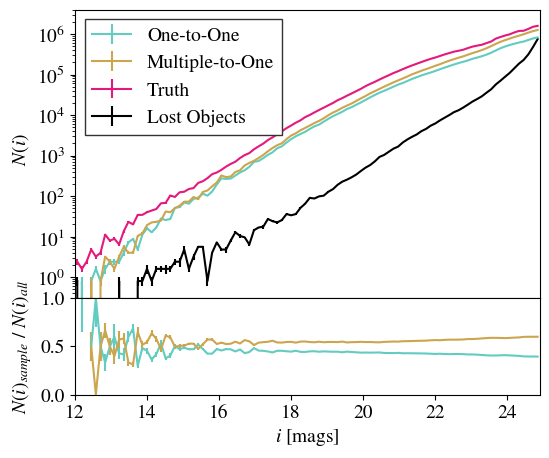

In [46]:
colorlist = ['#5e59e5', '#61ccbf', '#cca64f', '#e5197b']

fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [3, 1]}, figsize=(6,5))
plt.subplots_adjust(hspace=0.,wspace=0.)
axs[0].errorbar(nz_bin_centers, nz_oto, nz_sig_oto, color=colorlist[1])
axs[0].errorbar(nz_bin_centers, nz_otm, nz_sig_otm, color=colorlist[2])
axs[0].errorbar(nz_bin_centers, nz_truth, nz_sig_truth, color=colorlist[3])
# axs[0].errorbar(nz_bin_centers, nz_all, nz_sig_all, color=colorlist[0])
axs[0].errorbar(nz_bin_centers, nz_lost, nz_sig_lost, color='black', zorder=0)

axs[0].set_ylabel('  $N(i)$')

# axs[1].axhline(1,c='black',ls='--')
axs[1].errorbar(nz_bin_centers,np.divide(nz_oto,nz_all),
                propagate_division_error(np.divide(nz_oto,nz_all),nz_oto,nz_sig_oto,nz_all,nz_sig_all), color=colorlist[1])
axs[1].errorbar(nz_bin_centers,np.divide(nz_otm,nz_all),
                propagate_division_error(np.divide(nz_otm,nz_all),nz_otm,nz_sig_otm,nz_all,nz_sig_all), color=colorlist[2])
# axs[1].errorbar(nz_bin_centers,np.divide(nz_truth,nz_all),
#                 propagate_division_error(np.divide(nz_truth,nz_all),nz_truth,nz_sig_truth,nz_all,nz_sig_all), color=colorlist[3])
# axs[1].errorbar(nz_bin_centers,np.divide(nz_lost,nz_all),
#                 propagate_division_error(np.divide(nz_lost,nz_all),nz_lost,nz_sig_lost,nz_all,nz_sig_all), color='black', zorder=0)
axs[1].set_xlabel('$i$ [mags]')
# axs[1].set_ylim([12, 1])
# axs[1].set_ylabel('$N(i)_{sample}$ $/$ $N(i)_{all}$', labelpad=24)
axs[1].set_ylabel('$N(i)_{sample}$ $/$ $N(i)_{all}$', labelpad=5)

axs[0].legend(['One-to-One', 'Multiple-to-One', 'Truth', 'Lost Objects'], 
              loc='upper left', ncol=1, fancybox=False, framealpha=1, edgecolor='.2')

axs[0].set_ylim(.3,4e6)
axs[0].set_yscale('log')
axs[0].set_xlim(12,24.92)
axs[1].set_xlim(12,24.92)
axs[1].set_ylim(0, 1)

axs[0].get_xaxis().set_visible(False)

plt.savefig('mag_plot_Y5photz.png', format='png', dpi=300, bbox_inches='tight')

# Compute correlation functions

In [47]:
zedges = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]

In [48]:
nz_out = {}
nz_out['all'] = {}
nz_out['1t1'] = {}
nz_out['mtm'] = {}
nz_out['meas_other'] = {}
nz_out['artifact'] = {}
nz_out['true_lost'] = {}
nz_out['true_all'] = {}
dndz_out = {}
dndz_out['all'] = {}
dndz_out['1t1'] = {}
dndz_out['mtm'] = {}
dndz_out['meas_other'] = {}
dndz_out['artifact'] = {}
dndz_out['true_lost'] = {}
dndz_out['true_all'] = {}

theta_out = {}
theta_out['all'] = {}
theta_out['1t1'] = {}
theta_out['mtm'] = {}
theta_out['meas_other'] = {}
theta_out['artifact'] = {}
theta_out['true_lost'] = {}
theta_out['true_all'] = {}
w_out = {}
w_out['all'] = {}
w_out['1t1'] = {}
w_out['mtm'] = {}
w_out['meas_other'] = {}
w_out['artifact'] = {}
w_out['true_lost'] = {}
w_out['true_all'] = {}
cov_out = {}
cov_out['all'] = {}
cov_out['1t1'] = {}
cov_out['mtm'] = {}
cov_out['meas_other'] = {}
cov_out['true_lost'] = {}
cov_out['true_all'] = {}
cov_out['artifact'] = {}

In [49]:
len(tab_all[masks['all']])

30284837

In [50]:
zmask = (tab_all['photoz_mean'] > 0.6) & (tab_all['photoz_mean'] < 0.8)
zmask = (zmask) & (masks['all'])

len(tab_all[zmask])

5473172

In [51]:
for i in range(len(zedges)-1):
    print(i)
    for key in masks.keys():
        print(key)
        if 'true' not in key:
            zmask = (tab_all['photoz_mean'] > zedges[i]) & (tab_all['photoz_mean'] < zedges[i+1])
            zmask = (zmask) & (masks[key])
            cat_here = tc.Catalog(ra=tab_all['ra'][zmask], dec=tab_all['dec'][zmask], 
                                 patch_centers=cat_rnd.patch_centers, ra_units='deg', dec_units='deg')
            nz, zbins = calculate_z_distribution(tab_all['redshift_true'][zmask], zedges[i], zedges[i+1])
        else:
            zmask = (data_truth['redshift_true'][good_truth] > zedges[i]) & (data_truth['redshift_true'][good_truth] < zedges[i+1])
            zmask = (zmask) & (masks[key])
            cat_here = tc.Catalog(ra=data_truth['ra'][good_truth][zmask], dec=data_truth['dec'][good_truth][zmask],
                                 patch_centers=cat_rnd.patch_centers, ra_units='deg', dec_units='deg')
            nz, zbins = calculate_z_distribution(data_truth['redshift_true'][good_truth][zmask], zedges[i], zedges[i+1])
        theta, w, cov = compute_corr(cat_here, cat_rnd)
        theta_out[key][i] = theta
        w_out[key][i] = w
        cov_out[key][i] = cov
        nz_out[key][i] = nz
        dndz_out[key][i] = zbins
        
        # np.save(f'cov_DC2_DR6/cov_DC2_DR6_08_12_2024_Y1_photz_{key}_{i}', cov)

0
all
1t1
mtm
meas_other
artifact
true_all
true_lost
1
all
1t1
mtm
meas_other
artifact
true_all
true_lost
2
all
1t1
mtm
meas_other
artifact
true_all
true_lost
3
all
1t1
mtm
meas_other
artifact
true_all
true_lost
4
all
1t1
mtm
meas_other
artifact
true_all
true_lost


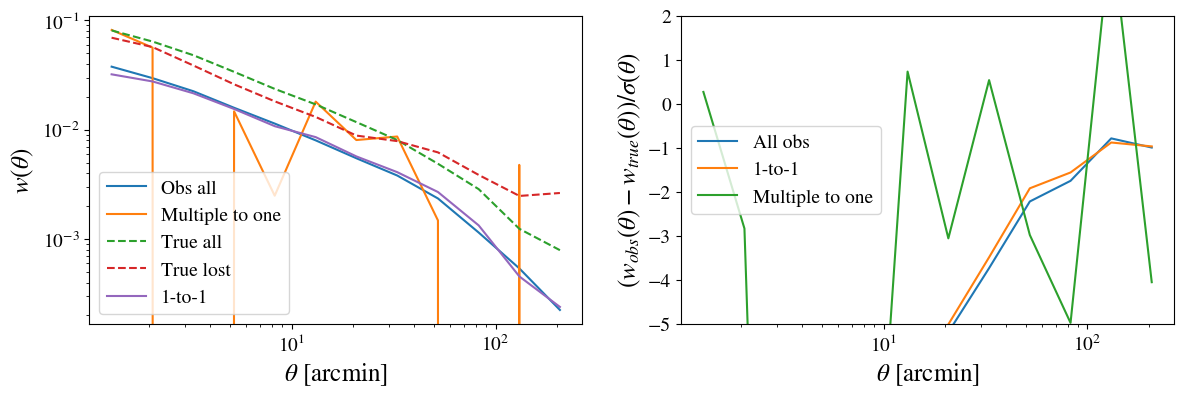

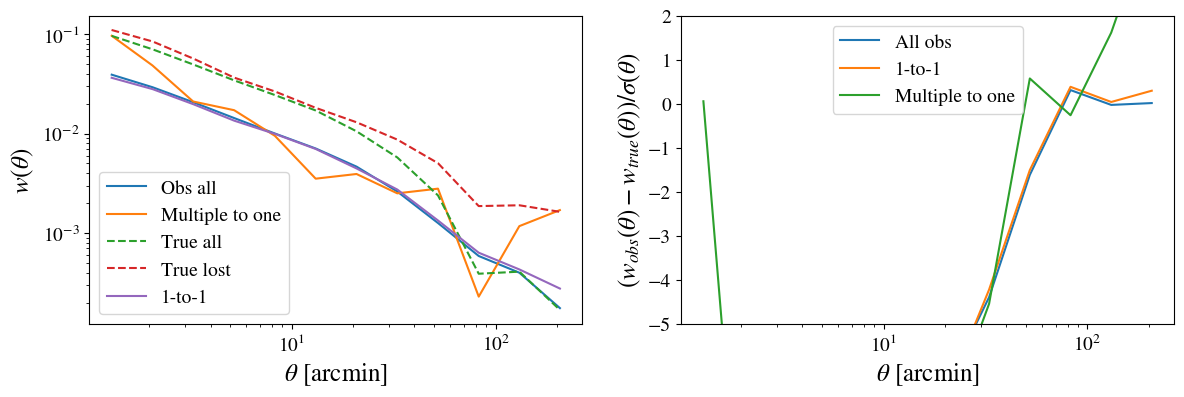

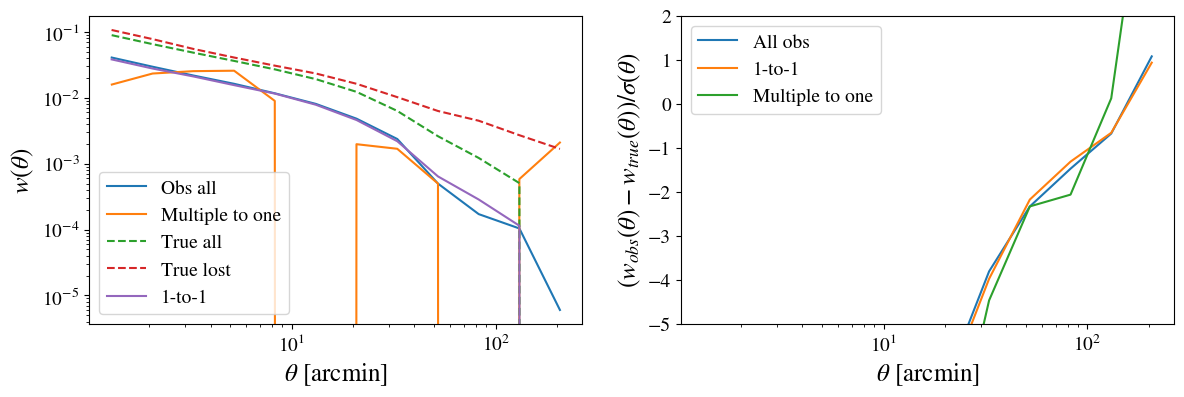

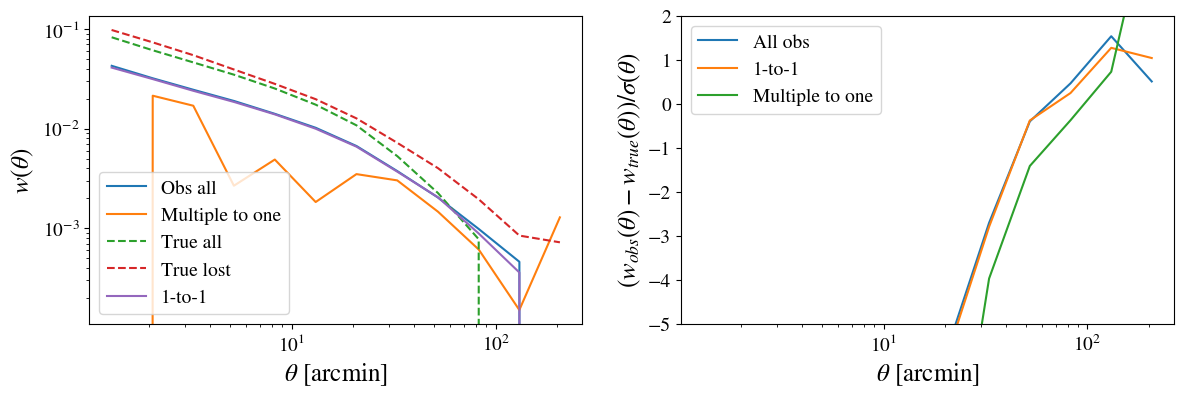

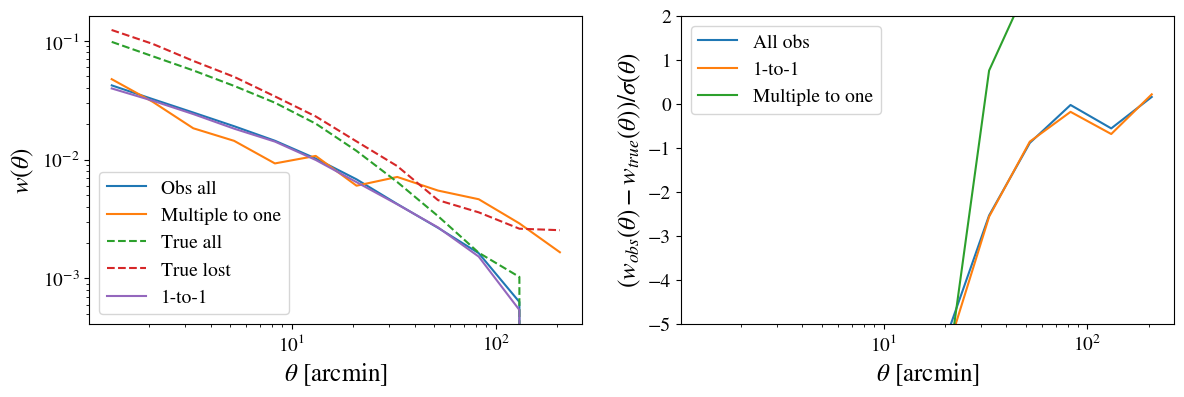

In [52]:
for ibin in range(5):
    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))
    ax[0].plot(theta_out['all'][ibin], w_out['all'][ibin], label='Obs all')
    ax[0].plot(theta_out['meas_other'][ibin], w_out['meas_other'][ibin], label='Multiple to one')
    ax[0].loglog(theta_out['true_all'][ibin], w_out['true_all'][ibin], label='True all', ls='--')
    ax[0].loglog(theta_out['true_lost'][ibin], w_out['true_lost'][ibin], label='True lost', ls='--')
    #ax[0].loglog(theta, w_out['artifact'][ibin], label='Artifacts')
    ax[0].loglog(theta_out['1t1'][ibin], w_out['1t1'][ibin], label='1-to-1')
    #ax[0].loglog(theta, w_out['mtm'][ibin], label='Many-to-many')
    ax[0].legend(loc='best')
    ax[0].set_xlabel(r'$\theta$ [arcmin]', fontsize=18)
    ax[0].set_ylabel(r'$w(\theta)$', fontsize=18)
    ax[1].plot(theta, (w_out['all'][ibin]-w_out['true_all'][ibin])/np.sqrt(np.diag(cov_out['true_all'][ibin])), label='All obs')
    ax[1].plot(theta, (w_out['1t1'][ibin]-w_out['true_all'][ibin])/np.sqrt(np.diag(cov_out['true_all'][ibin])), label='1-to-1')
    ax[1].plot(theta, (w_out['meas_other'][ibin]-w_out['true_all'][ibin])/np.sqrt(np.diag(cov_out['true_all'][ibin])), label='Multiple to one')
    ax[1].legend(loc='best')
    ax[1].set_xscale('log')
    ax[1].set_ylim(-5, 2)
    ax[1].set_xlabel(r'$\theta$ [arcmin]', fontsize=18)
    ax[1].set_ylabel(r'$(w_{obs}(\theta)-w_{true}(\theta))/\sigma(\theta)$', fontsize=18)

In [53]:
w_out_all = dict()
for i in range(5):
    # theta_out_all['theta'] = theta
    w_out_all[f'theta_obs_all_{i}'] = theta_out['all'][i]
    w_out_all[f'theta_true_all_{i}'] = theta_out['true_all'][i]
    w_out_all[f'theta_true_lost_{i}'] = theta_out['true_lost'][i]
    w_out_all[f'theta_artifact_{i}'] = theta_out['artifact'][i]
    w_out_all[f'theta_obs_1to1_{i}'] = theta_out['1t1'][i]
    w_out_all[f'theta_obs_manytomany_{i}'] = theta_out['mtm'][i]
    w_out_all[f'theta_obs_other_{i}'] = theta_out['meas_other'][i]
    w_out_all[f'w_obs_all_{i}'] = w_out['all'][i]
    w_out_all[f'w_true_all_{i}'] = w_out['true_all'][i]
    w_out_all[f'w_true_lost_{i}'] = w_out['true_lost'][i]
    w_out_all[f'w_artifact_{i}'] = w_out['artifact'][i]
    w_out_all[f'w_obs_1to1_{i}'] = w_out['1t1'][i]
    w_out_all[f'w_obs_manytomany_{i}'] = w_out['mtm'][i]
    w_out_all[f'w_obs_other_{i}'] = w_out['meas_other'][i]
    w_out_all[f'w_err_obs_all_{i}'] = np.sqrt(np.diag(cov_out['all'][i]))
    w_out_all[f'w_err_true_all_{i}'] = np.sqrt(np.diag(cov_out['true_all'][i]))
    w_out_all[f'w_err_artifact_{i}'] = np.sqrt(np.diag(cov_out['artifact'][i]))
    w_out_all[f'w_err_true_lost_{i}'] = np.sqrt(np.diag(cov_out['true_lost'][i]))
    w_out_all[f'w_err_obs_1to1_{i}'] = np.sqrt(np.diag(cov_out['1t1'][i]))
    w_out_all[f'w_err_obs_manytomany_{i}'] = np.sqrt(np.diag(cov_out['mtm'][i]))
    w_out_all[f'w_err_obs_other_{i}'] = np.sqrt(np.diag(cov_out['meas_other'][i]))
    # w_out_all['rr'] = rr.npairs
    # w_out_all[f'rr_{i}'] = rr_out[i]

In [54]:
tab_out = astropy.table.Table(w_out_all)

In [55]:
tab_out.write('DC2_DR6_wtheta_09_03_2024_Y5_photz.fits.gz', overwrite=True)

In [56]:
np.save('DC2_DR6_Nz_09_03_2024_Y5_photz.npy', [nz_out, dndz_out])